# Notebook to explore Gaia DR3 data
author: [Mathieu Renzo](mrenzo@flatironinstitute.org)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.io import fits
%load_ext autoreload
%autoreload 2

In [2]:
# check we use DR3
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

In [3]:
# never download more than 100 stars for testing, set to -1 for no limit
Gaia.ROW_LIMIT = 6700 # 100

In [4]:
# read the data
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')
print(gaiadr3_table)

TAP Table name: gaiadr3.gaiadr3.gaia_source
Description: This table has an entry for every Gaia observed source as published with this data release. It contains the basic source parameters, in their final state as processed by the Gaia Data Processing and Analysis Consortium from the raw data coming from the spacecraft. The table is complemented with others containing information specific to certain kinds of objects (e.g.~Solar--system objects, non--single stars, variables etc.) and value--added processing (e.g.~astrophysical parameters etc.). Further array data types (spectra, epoch measurements) are presented separately via Datalink resources.
Num. columns: 152


## Orion nebula

Following [Schoettler et al. 2022](http://arxiv.org/abs/2004.13730) we
query stars around the orion nebula

In [5]:
# query data around Orion
Orion_center = SkyCoord(ra=83.822 , dec=-5.391, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(1, u.deg)
height = width
orion_cluster_all = Gaia.query_object_async(coordinate=Orion_center, width=width, height=height)

INFO: Query finished. [astroquery.utils.tap.core]


In [6]:
# to check available data
# for col in query.columns:
#     print(col)

## Filter out bad data
For more info see Lindegren et al. 2018, 2022, Maiz-Apellaniz et al. 2018, 2022, 2023

In [7]:
print("Quality cuts:")
# renormilized unit weigh error
good_ruwe        = orion_cluster_all['ruwe'] < 1.4
print("Lost to good_ruwe",  np.sum(1-good_ruwe))
# excess astrometric noise
good_astro_noise = orion_cluster_all["astrometric_excess_noise"] < 1
print("Lost to good_astro_noise",  np.sum(1-good_astro_noise))
# visibility periods used for astrometric solution
good_vis         = orion_cluster_all['visibility_periods_used']>10
print("Lost to good_vis",  np.sum(1-good_vis))
# parallax relative error < 10%
good_parallax    = orion_cluster_all['parallax_over_error'] > 10
print("Lost to good_parallax",  np.sum(1-good_parallax))
# combination
index_good             = good_ruwe & good_astro_noise & good_vis & good_parallax
# verify number of stars left
print("-----------")
print("Of the initial", len(orion_cluster_all['ra']), "we retain only", len(orion_cluster_all['ra'][index_good]), "stars")

Quality cuts:
Lost to good_ruwe 483
Lost to good_astro_noise 2623
Lost to good_vis 833
Lost to good_parallax 3191
-----------
Of the initial 6604 we retain only 2108 stars


## Visualize data

In [8]:
ra = orion_cluster_all["ra"]
ra_err = orion_cluster_all["ra_error"].to(u.degree)
dec = orion_cluster_all["dec"]
dec_err = orion_cluster_all["dec_error"].to(u.degree)

positions = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
ra_rad = positions.ra.wrap_at(180 * u.deg).radian
dec_rad = positions.dec.radian

### Where in the sky are we looking?

See [astropy Skycoord docs](https://docs.astropy.org/en/stable/coordinates/skycoord.html)

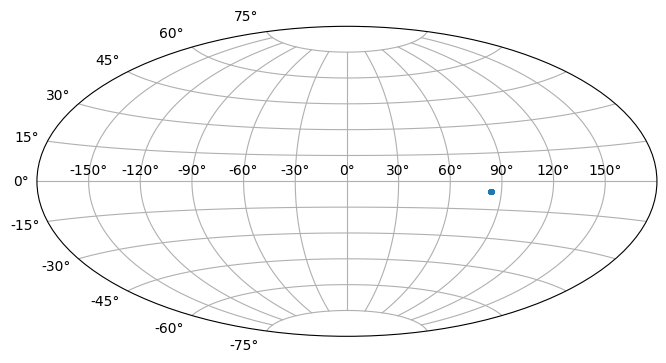

In [9]:
fig = plt.figure(figsize=(8,4.2))
ax = fig.add_subplot(111, projection="aitoff")
ax.grid(True)
ax.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)


<ErrorbarContainer object of 3 artists>

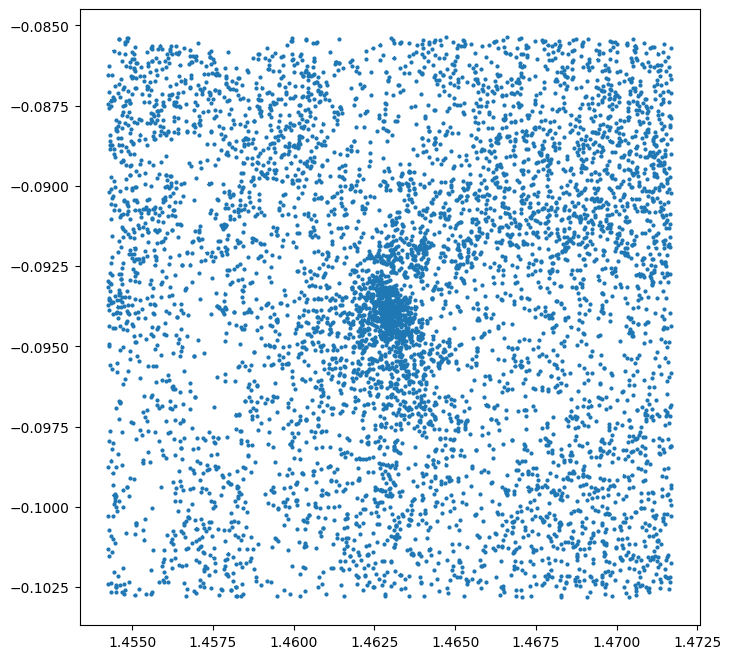

In [15]:
# zoom in
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(100, 100)
ax = fig.add_subplot(gs[:, :])

ax.errorbar(ra_rad, dec_rad, yerr = dec_err.value , xerr=ra_err.value, lw=0, elinewidth=3, markersize=2, marker='o')
# ax.set_xlabel(r"RA [deg]")
# ax.set_ylabel(r"DEC [deg]")


*Suggestion*: try to visualize the disk structure of the Galaxy with a
similar plot (N.B.: may require downloading a large chunck of the DR3 catalog)

In [ ]:
# Limit number of stars!!
Gaia.ROW_LIMIT = 10

Gal_center = SkyCoord(ra=0, dec=0, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(359, u.deg)
height = width
MW_Galaxy = Gaia.query_object_async(coordinate=Gal_center, width=width, height=height)